### Image Recognition Using Deep Convolution Network
#### Author : Shubhajit Basak

#### Part I 
#### Triplet Loss Function
In this part we are designing a Program a network in Keras with a triplet loss function

#### Load all the Packages

In [1]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from keras.layers import Input, Lambda
from keras.utils import np_utils
from keras.datasets import mnist
from emnist import extract_training_samples
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import keras

C:\ProgramData\Anaconda3\envs\ratenv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Get Data

In [2]:
# Get data 
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

I am also using the EMNIST Dataset to get some sample data from the alphabet dataset to train for the unknown data label

In [3]:
alpha_img, alpha_labels = extract_training_samples('letters')

#### Part I - Section 1 :
#### Model with Triplet Loss Design 

In [4]:
# Get the image 
def get_image(label, test=False):
    """Choose an image from our training or test data with the
    given label."""
    if test:
        y = y_test; X = X_test
    else:
        y = y_train; X = X_train
    idx = np.random.randint(len(y))
    while y[idx] != label:
        # keep searching randomly!
        idx = np.random.randint(len(y))
    return X[idx]

In [5]:
# Get triplet
def get_triplet(test=False):
    """Choose a triplet (anchor, positive, negative) of images
    such that anchor and positive have the same label and
    anchor and negative have different labels."""
    n = a = np.random.randint(10)
    while n == a:
        # keep searching randomly!
        n = np.random.randint(10)
    a, p = get_image(a, test), get_image(a, test)
    n = get_image(n, test)
    return a, p, n

In [6]:
# Generate Triplet
def generate_triplets(test=False):
    """Generate an un-ending stream (ie a generator) of triplets for
    training or test."""
    while True:
        list_a = []
        list_p = []
        list_n = []

        for i in range(batch_size):
            a, p, n = get_triplet(test)
            list_a.append(a)
            list_p.append(p)
            list_n.append(n)
            
        A = np.array(list_a, dtype='float32')
        P = np.array(list_p, dtype='float32')
        N = np.array(list_n, dtype='float32')
        # a "dummy" label which will come in to our identity loss
        # function below as y_true. We'll ignore it.
        label = np.ones(batch_size) 
        yield [A, P, N], label

In [7]:
############## Loss ###########################

def identity_loss(y_true, y_pred):
    """This loss function just takes the mean of y_pred. Because of the
    way we wire the network (see complete_model below), y_pred is the
    output of the triplet loss, so minimising it is what we want to
    do."""
    return K.mean(y_pred)

def triplet_loss(x):
    """The triplet loss is ||A - P|| - ||A - N|| + alpha, where ||.||
    is the Euclidean norm. Notice that this is not a loss function in the
    format expected by Keras, ie f(y_true, y_pred)."""
    anchor, positive, negative = x
    
    # XXX YOUR CODE HERE: CALCULATE loss. USE K.
    pos_dist = K.sum(K.square(anchor-positive), axis=-1)
    neg_dist = K.sum(K.square(anchor-negative), axis=-1)
    loss = K.sum(K.maximum(pos_dist - neg_dist + alpha, 0), axis=0)
    
    return loss

In [8]:
# Embedding Model - The following model will take the image and return the embedding layer 
def embedding_model():
    """A tiny model similar to the network we used for MNIST
    classification. We assume the architecture should be good for
    MNIST embedding. Its input is an image and output is an embedding,
    not a classification, so the final layer is not a softmax. We
    don't compile or add a loss since this will become a component in
    the complete model below."""
    input_shape = (imsize,imsize,1)
    model = Sequential()

    # XXX YOUR CODE HERE: ADD SOME LAYERS ENDING IN AN OUTPUT LAYER
    # APPROPRIATE FOR THE EMBEDDING.
    model.add(Convolution2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(embedding_dim))
    
    return model

In [9]:
def complete_model(base_model):
    """This part of the model is quite tricky. Rather than a Sequential
    model, we declare a Model and say which are its inputs and
    outputs, and we declare how the outputs are calculated from the
    inputs. In particular, there are no layers in this model, *other
    than* the layers in the embedding model discussed above.

    A further complication is that our triplet loss can't be
    calculated as a function of y_true and y_predicted as
    usual. Instead we calculate the triplet loss as an extra Lambda
    layer. Then the Model's loss is set to be equal to the triplet
    loss via the identity function."""

    
    input_1 = Input((imsize, imsize, 1))
    input_2 = Input((imsize, imsize, 1))
    input_3 = Input((imsize, imsize, 1))

    # call the base_model three times to get A, P, N

    # XXX YOUR CODE HERE.
    
    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)
    
    loss = Lambda(triplet_loss)([A, P, N]) 
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model.compile(loss=identity_loss, optimizer=Adam(LR))
    return model

#### Part I - Section 2 :
#### Train the Model with MNIST Dataset

In [10]:
############## Settings ###########################

imsize = 28

# XXX you might like to play with some of these hyperparameters
batch_size = 100
# 2D is interesting for visualisation, but higher allows more "space"
# to achieve accuracy in complex domains, eg 128 is common for
# faces. but MNIST is simple, so maybe 2 is enough for us anyway.
embedding_dim = 2 
LR = 0.0001 # be careful: too large will be unstable for our data
EPOCHS = 30
alpha = 0.1 # interesting to think about different values


############## Main ###############################

# create the data generators
train_generator = generate_triplets()
test_generator = generate_triplets(test=True)

# instantiate the model and take a look

# XXX YOUR CODE HERE: create the embedding model and then use
# that to create the complete model

base_model = embedding_model()
model = complete_model(base_model)


print(model.summary())

# fit

# XXX YOUR CODE HERE: call fit_generator() to fit the model.

history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=EPOCHS, 
                    verbose=2, 
                    steps_per_epoch=20, 
                    validation_steps=30)
# model.save_weights("model.h5")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2)            1198850     input_1[0][0]                    
                                                                 input_2[0][0]                    
          

#### Part I - Section 3 :
#### Plot the loss over epoch to show its decreasing over epoch 

dict_keys(['val_loss', 'loss'])


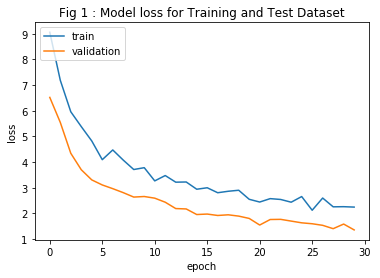

In [11]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Fig 1 : Model loss for Training and Test Dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("LossTriplet.png")
plt.show()

#### Visualise the Embedding (save the fihure in the local disk)

To get the embedding I am creating a new Model with the existing Trained Model above only using the Embedding Layer (Base Model). This will also be used while building the recgnitionfunctionfunction. We do not to need to train this model, input of this model is the image (28 X 28 X 1) and output is thye embedding layer   

In [12]:
input_embd = Input((imsize, imsize, 1)) # Input layout with the shape of embedding
model_embd = Model(inputs=input_embd, outputs=base_model(input_embd))
model_embd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 2)                 1198850   
Total params: 1,198,850
Trainable params: 1,198,850
Non-trainable params: 0
_________________________________________________________________


In [13]:
################# Visualisation ###################

# we add an extra 28 pixels to allow for images whose bottom-left is
# at the top or right border
canvas_size = 4000
canvas = np.zeros((canvas_size+imsize, canvas_size+imsize), dtype=float)

def loc2pix(x, size):

    """All values in x are in [-1, 1], we want it in [0, size]."""
    # add 1 to make it non-negative, squeeze to remove trivial
    # dimension and transform.
    x = (((1.0 + x.squeeze()) / 2) * size).astype(int)
    assert np.all(x >= 0) and np.all(x < size)
    return x

for ib, batch in enumerate(test_generator):
    APN, label = batch
    for i in range(batch_size):
        
        # get the embedding for a, p, n: each should be in [-1, 1]^2
        
        # XXX YOUR CODE HERE. Set a to be the embedding of APN[0][i:i+1],
        # and similarly p for APN[1][i:i+1] and n for APN[2][i:i+1].
        # Think about what you need to call.
        a = model_embd.predict(APN[0][i:i+1])
        p = model_embd.predict(APN[1][i:i+1])
        n = model_embd.predict(APN[2][i:i+1])
        
        # transform a, p, n to pixel-space [0, 4028]^2
        a = loc2pix(a, canvas_size)
        p = loc2pix(p, canvas_size)
        n = loc2pix(n, canvas_size)

        # paint the image of each digit onto the canvas
        canvas[a[0]:a[0]+imsize, a[1]:a[1]+imsize] = APN[0][i].squeeze()
        canvas[p[0]:p[0]+imsize, p[1]:p[1]+imsize] = APN[1][i].squeeze()
        canvas[n[0]:n[0]+imsize, n[1]:n[1]+imsize] = APN[2][i].squeeze()
        
    break # one batch of 100 samples is enough for visualisation

fig, ax = plt.subplots(figsize=(40, 40)) # we have to make it large to avoid subsampling
ax.matshow(canvas)
plt.title("Fig 2 : Keras MNIST Triplet Layout")
plt.savefig("keras_mnist_triplet_layout.png")
plt.close()


#### Part I - Section 4 :
#### Program a recognition function 

We have to build a recognition function which will take the images and predict if the images are of numbers, it should also predict unknown label as we provide some image other than numbers. We will take advantage of the 2 dimensional embedding space, as the embedding for unknown images will be far from the numbers in the embedding space. We will build a new Neural Network Model with one dense and one softmax layer with 11 categories as one extra for the unknown label.

To train the model we need some dummy data for the unknown label, for this we will use 10000 images of characters from the EMNIST dataset and predict their embedding from our pretrained model that will create data for the unknown label in our new model.

In [14]:
# Number of classes 11 as we have an extra label for unknown image
num_classes = 11
# Get the embedding for X_Train
matTrain = model_embd.predict(X_train)
# Get the embedding for Unknown Lebel Images (10000 from EMNIST Character dataset)
matTrain_ukn = model_embd.predict(alpha_img[0:10000].reshape(10000,28,28,1))
# Concatenate to get 70000 training data for new model
matTrainUpdt = np.concatenate((matTrain,matTrain_ukn),axis=0)

# Create label data 
# We will set label as 10 for the unknown labels
# which we will append with the existing y_train
y1 = y_train.tolist()
y1.extend([10]*10000)
y1 = np.array(y1)
# Create One Hot Vector for the newly created y_train data
y_train_cat = keras.utils.to_categorical(y1, num_classes)

Create the new model which will take the embedding data and pass it through a single dense layer and a softmax layer with 11 nodes as it has 11 categories

In [15]:
model_pred_img = Sequential()
model_pred_img.add(Dense(32, activation='relu',input_shape=(embedding_dim,))) # Dense Layer with RELU
model_pred_img.add(Dense(num_classes, activation='softmax')) # Dense Layer with Softmax
# Compile model with categorical cross entropy
model_pred_img.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])
print(model_pred_img.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_4 (Dense)              (None, 11)                363       
Total params: 459
Trainable params: 459
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# Fit the model with the newly created data with 10 epochs
model_pred_img.fit(matTrainUpdt, y_train_cat,
                batch_size=batch_size,
                epochs=10)

Epoch 1/10
70000/70000 [==============================] - ETA: 2:42 - loss: 4.6916 - acc: 0.030 - ETA: 16s - loss: 4.0991 - acc: 0.045 - ETA: 9s - loss: 3.9145 - acc: 0.0538 - ETA: 7s - loss: 3.8231 - acc: 0.065 - ETA: 5s - loss: 3.5434 - acc: 0.084 - ETA: 5s - loss: 3.3219 - acc: 0.104 - ETA: 4s - loss: 3.1470 - acc: 0.134 - ETA: 4s - loss: 2.9732 - acc: 0.168 - ETA: 3s - loss: 2.8612 - acc: 0.201 - ETA: 3s - loss: 2.7649 - acc: 0.229 - ETA: 3s - loss: 2.6901 - acc: 0.255 - ETA: 3s - loss: 2.6003 - acc: 0.286 - ETA: 3s - loss: 2.5435 - acc: 0.304 - ETA: 2s - loss: 2.4917 - acc: 0.321 - ETA: 2s - loss: 2.4322 - acc: 0.338 - ETA: 2s - loss: 2.3919 - acc: 0.348 - ETA: 2s - loss: 2.3460 - acc: 0.359 - ETA: 2s - loss: 2.3166 - acc: 0.370 - ETA: 2s - loss: 2.2891 - acc: 0.382 - ETA: 2s - loss: 2.2541 - acc: 0.399 - ETA: 2s - loss: 2.2304 - acc: 0.410 - ETA: 1s - loss: 2.2082 - acc: 0.420 - ETA: 1s - loss: 2.1891 - acc: 0.428 - ETA: 1s - loss: 2.1636 - acc: 0.437 - ETA: 1s - loss: 2.1455 - a

70000/70000 [==============================] - ETA: 4s - loss: 0.4504 - acc: 0.810 - ETA: 2s - loss: 0.4292 - acc: 0.850 - ETA: 2s - loss: 0.4245 - acc: 0.856 - ETA: 2s - loss: 0.4312 - acc: 0.857 - ETA: 2s - loss: 0.4270 - acc: 0.857 - ETA: 2s - loss: 0.4289 - acc: 0.858 - ETA: 2s - loss: 0.4251 - acc: 0.861 - ETA: 2s - loss: 0.4289 - acc: 0.859 - ETA: 2s - loss: 0.4316 - acc: 0.858 - ETA: 2s - loss: 0.4333 - acc: 0.856 - ETA: 2s - loss: 0.4344 - acc: 0.855 - ETA: 2s - loss: 0.4367 - acc: 0.854 - ETA: 2s - loss: 0.4357 - acc: 0.854 - ETA: 2s - loss: 0.4347 - acc: 0.854 - ETA: 2s - loss: 0.4334 - acc: 0.854 - ETA: 2s - loss: 0.4339 - acc: 0.854 - ETA: 2s - loss: 0.4325 - acc: 0.854 - ETA: 1s - loss: 0.4307 - acc: 0.855 - ETA: 1s - loss: 0.4304 - acc: 0.856 - ETA: 1s - loss: 0.4300 - acc: 0.856 - ETA: 1s - loss: 0.4296 - acc: 0.856 - ETA: 1s - loss: 0.4301 - acc: 0.856 - ETA: 1s - loss: 0.4306 - acc: 0.856 - ETA: 1s - loss: 0.4308 - acc: 0.856 - ETA: 1s - loss: 0.4322 - acc: 0.855 - ETA

##### Define the Recognise Function: 
Now we have a model trained with the Embedding data and will predict the class, but as the reciognise function will take the image as output we will first predict the embedding with the previously trained embedding model with triplet loss and pass the embedding to our newly trained model to predict the labels 

In [17]:
def recognise_digit(img):
    img = img.reshape(1,28,28,1)
    im1 = model_embd.predict(img)
    #print(im1)
    result = model_pred_img.predict(im1)
    if(result.argmax()==10):
        return "UnKnown"
    else:
        return result.argmax()

#### Part I - Section 5 :
#### Test the Network with both Known and Unknown Images 

Recognised Digit: 4


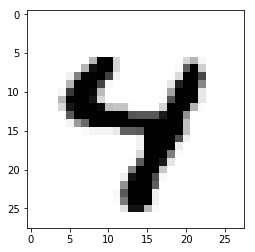

In [18]:
# Test with one digit data from MNIST 
img = X_test[1010].reshape(1,28,28,1)
plt.imshow(X_test[1010].reshape(28,28), cmap='Greys')
print("Recognised Digit: "+ str(recognise_digit(img)))

Recognised Digit: UnKnown


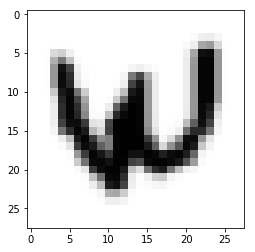

In [19]:
# Test with one character data from EMNIST Dataset
img = alpha_img[1000] #.reshape(1,28,28,1)
plt.imshow(alpha_img[1000].reshape(28,28), cmap='Greys')
print("Recognised Digit: "+ str(recognise_digit(img)))

#### Calculate Accuracy Of the Model:

In [20]:
from sklearn.metrics import accuracy_score

# Get the Predictaed label for y_test
y_predict = [recognise_digit(X_test[i]) for i  in range(len(X_test))]

# Calculate Accuracy
print("Accuracy : " + str(accuracy_score(y_test,y_predict)))

Accuracy : 0.8433


#### Part II

In this part we will take a pretrained Image Recognition Model available online and will use it to Cluster Images on same Bin

#### Part II - Section 6 :
#### Pre-Trained Deep Convolution Network Face Model  

Here we have used the VGG Face Model with 22 layers and 37 deep units, the model is developed by the Researchers from the Oxford. 
I have doenloaded the weight and loaded them to a model I have created with the same model construced locally.

The weight can be found [here](https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing)

The Original paper can be found [here](http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf)

The Layer Structure and Image preconstruction I have followed from this [blog](https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/)

In [21]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Activation
from keras.layers import Input, Lambda
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, save_img, img_to_array

Contruct the model so that it can match with the VGG Facenet Model 

In [22]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 128)     73856     
__________

In [24]:
# Load the Pre trained weight 
from keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

We will use upto the previous layer of the actication layer to get the embedding of 2622

In [25]:
vgg_face_descriptor = Model(inputs=model.layers[0].input
                            , outputs=model.layers[-2].output)  # Remove the last activation layer

#### Part II - Section 7 :
#### Use the Model To create clustering  

#### Data Preparation

I have manually Contructed 16 different images of four players each with size 224 * 224 and placed in the Dataset Folder and get the embedding for the 16 Images

In [26]:
# Take the image file and preporocess to get the inputb for the VGG16 Model
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224)) # Load the image
    img = img_to_array(img) # Convert into array
    img = np.expand_dims(img, axis=0) # Reshape to (1 * 224 * 224 * 3)
    img = preprocess_input(img) # Pre process the image to get the data for VGG 16 Model
    return img

Now I will create a list of the embedding, original image and the labels for the input of K-Means

In [27]:
import os

# Get Directory
directory = os.fsencode("Dataset/")
img_embd = [] # Store the image embedding  
orig_img = [] # Store the Original Image
label =list() # Store the Labels
for file in os.listdir(directory):
    # Read the File
    filename = os.fsdecode(file)
    # Get the Embedding
    img_representation = vgg_face_descriptor.predict(preprocess_image('Dataset/'+filename))[0,:]
    # Append the Original Image
    orig_img.append(load_img('Dataset/'+filename, target_size=(224, 224)))
    # Append the Embedding
    img_embd.append(img_representation)
    # Create the labels
    if("Messi" in filename):
        label.append(0)
    elif("Ronaldo" in filename):
        label.append(1)
    elif("Salha" in filename):
        label.append(2)
    elif("Suaraze" in filename):
        label.append(3)
    print(filename)

Messi1.png
Messi2.png
Messi3.png
Messi4.png
Ronaldo1.png
Ronaldo2.png
Ronaldo3.png
Ronaldo4.png
Salha1.png
Salha2.png
Salha3.png
Salha4.png
Suaraze1.png
Suaraze2.png
Suaraze3.png
Suaraze4.png


As we have a 2622 dimensional emedding layer to plot the embedding in 2 Dimensional Space I am using the Dimensionality Reduction Technique PCA with two Principle Component so that I can Plot the Images in 2 D Space

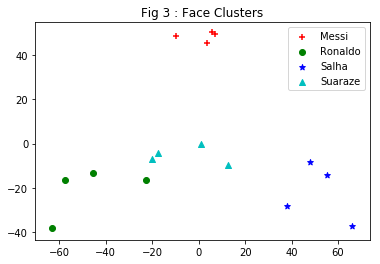

In [28]:
from sklearn.decomposition import PCA

# Fit the data in the 2D PCA Model
pca = PCA(n_components=2).fit(img_embd)
pca_2d = pca.transform(img_embd)

# Plot the PCA Data to see how it fits in the 2D Space
import pylab as pl
for i in range(0, pca_2d.shape[0]):
    if label[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif label[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
    elif label[i] == 2:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
    elif label[i] == 3:
        c4 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='c',marker='^')
pl.legend([c1, c2, c3, c4], ['Messi', 'Ronaldo','Salha','Suaraze'])
pl.title('Fig 3 : Face Clusters')
plt.savefig("FaceClusters_Signs.png")
pl.show()

As we can see above the data for different players has been segregated in the 2d space

#### Cluster the data with K-Means Clustering method

Lets find the optimal value of K with the Elbow method 

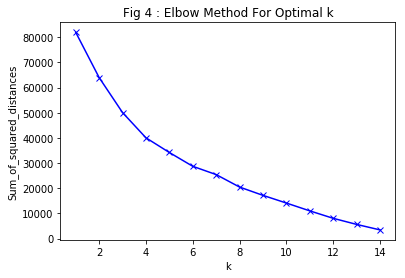

In [29]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(img_embd)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Fig 4 : Elbow Method For Optimal k')
plt.savefig("Elbow_output.png")
plt.show()

We can see there is a possible elbow at K = 4 as expected fron the data, so we will pass k = 4 to the K-Means

Here we will plot the PCA points clustered by the K Means and color the Points by the Cluster Labels found the K-Means Algorithm

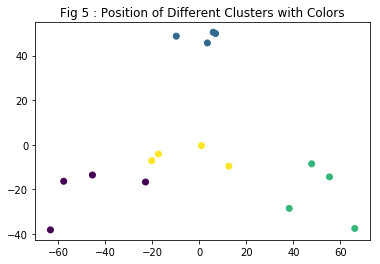

In [30]:
# K-Means with k = 4
kmeans = KMeans(n_clusters=4, random_state=111)
kmeans.fit(img_embd)
pl.figure('K-means with 4 clusters')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_) # Color by the cluster labels
pl.title("Fig 5 : Position of Different Clusters with Colors")
plt.savefig("K_MeansClusters.png")
pl.show()

From Fig 2 and Fig 4 we can see the K-Means Clustered the Images correctly in the same clusters  for 4 different players

#### Part II - Section 8 :
#### Plot the images in the window to show the images of same players are clustered together  

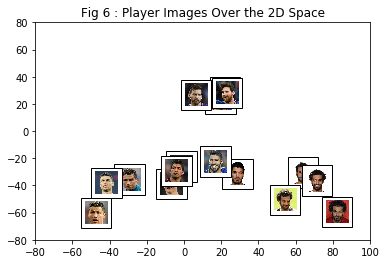

In [31]:
import matplotlib.pyplot as PLT
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png

# Create the Figure
fig = PLT.gcf()
fig.clf() # Clear the Figure
ax = PLT.subplot(111) # Create a subplot

for i in range(0, pca_2d.shape[0]):
    arr_img = orig_img[i] # Take the Image from the array of Images
    imagebox = OffsetImage(arr_img, zoom=.1) # Create Image Box with Offset
    xy = [pca_2d[i,0],pca_2d[i,1]]  # Get the coordinates to position this image from PCA Value
    # Cteate the Annotation Box
    ab = AnnotationBbox(imagebox, xy,
        xybox=(30., -30.), # Set the size of the Box
        xycoords='data',
        boxcoords="offset points")                                  
    ax.add_artist(ab)

# Set the X and Y axis Span to fit all the images in the window
ax.set_xlim(xmin=-80,xmax=100)
ax.set_ylim(ymin=-80,ymax=80)
plt.title("Fig 6 : Player Images Over the 2D Space")
plt.savefig("PlotImages.png")
PLT.draw()
PLT.show()

#### Part II - Section 9 :
#### Face Detection with One Shot Learning

With the above face embedding we can create a face detector using One Shot Learning, where we will save a single image of each person and compare their embedding with the embedding of the face detected in the camera screen. 

One major advantage is we do not have to train the model with new faces, when a new person's image has been added to our database it will automatically compare the embedding with that image and classify it.

Create a database with images captured by the webcam of the laptop - 

Method - 
   1. Run the following code
   2. Press Enter to capture the images stored in the Dataset/FaceDetector Folder
   3. Take the best picture rename the files with the actual name and discard others
   4. Press Esc to close the window

In [3]:
import glob
import cv2
import os

In [4]:
def createDataset():
    cam = cv2.VideoCapture(0)

    face_detector = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

    count = 0
    while(True):
        ret, img = cam.read()
        #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(img, 1.3, 5)
        for (x,y,w,h) in faces:
            x1 = x
            y1 = y
            x2 = x+w
            y2 = y+h
            cv2.rectangle(img, (x1,y1), (x2,y2), (255,255,255), 2)     
            count += 1
            cv2.imshow('image', img)

        k = cv2.waitKey(200) & 0xff # Press 'ESC' for exiting video
        if k == 27:
            break
        elif k == 13: # Press Enter to capture the images detected in the screen
            # Save the captured image into the datasets folder
            cv2.imwrite("Dataset/FaceDetector/User_" + str(count) + ".jpg", img[y1:y2,x1:x2])

    cam.release()
    cv2.destroyAllWindows()

In [5]:
# Call CreateDataset() function
createDataset()

#### Create embedding Dictionary for the Database Images

We will now create a dictionary of embedding vectors for each image from our database, key will be the name of the file and value will be the embedding vectors.

In [6]:
def create_input_image_embeddings():
    input_embeddings = {}

    for file in glob.glob("Dataset/FaceDetector/*.jpg"):
        person_name = os.path.splitext(os.path.basename(file))[0]
        #print(person_name)
        image_file = cv2.imread(file, 1) # read the image
        # Convert the image in correct shape required for our Model
        img = cv2.resize(image_file,(224,224)) 
        img = np.expand_dims(img, axis=0)
        input_embeddings[person_name] = vgg_face_descriptor.predict(img)[0,:] # Save the embeddings for the image 
                                                                              # in the dictionary
    return input_embeddings

##### Create the Face Recognition function 

Logic :
   * Detect the faces with in the camera window
   * For each face detected in the window calculate the embedding and compare the euclidean distance with the images stored in the  database
   * Return a match when the euclidean distance is less than a pre-defined threshold
   * This threshold needs to be adjusted according to the data

In [ ]:
def recognize_face(face_image, input_embeddings):
    # Inputs: 
    # face_image - input image
    # input_embeddings - dictionary containing the embedding of database images
    
    # Resize the images according to the expected input of the model
    face_image = cv2.resize(face_image,(224,224))
    face_image = np.expand_dims(face_image,axis=0)
    embedding = vgg_face_descriptor.predict(face_image)[0,:] # get the embedding
    
    minimum_distance = 200
    name = None
    
    # Loop over  names and encodings.
    for (input_name, input_embedding) in input_embeddings.items():
        
        # Calculate theDistances
        euclidean_distance = np.linalg.norm(embedding-input_embedding)
        

        print('Euclidean distance from %s is %s' %(input_name, euclidean_distance))

        
        if euclidean_distance < minimum_distance:
            minimum_distance = euclidean_distance
            name = input_name
    
    # Distance Threshold as 100 (change this value accordingly)
    if minimum_distance < 100:
        return str(name +":" + str(euclidean_distance))
    else:
        return None

#### Detect images through webcam and show the detected labels with the distances

In [7]:
def recognize_faces_in_cam(input_embeddings):
    

    cv2.namedWindow("Face Recognizer")
    vc = cv2.VideoCapture(0)
   

    font = cv2.FONT_HERSHEY_SIMPLEX
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
    
    
    while vc.isOpened():
        _, frame = vc.read()
        img = frame
        height, width, channels = frame.shape

        
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        # Loop through all the faces detected 
        identities = []
        for (x, y, w, h) in faces:
            x1 = x
            y1 = y
            x2 = x+w
            y2 = y+h

           
            
            face_image = frame[max(0, y1):min(height, y2), max(0, x1):min(width, x2)]   
            
            # Identify the faces detected in the cam
            identity = recognize_face(face_image, input_embeddings)

            if identity is not None:
                img = cv2.rectangle(frame,(x1, y1),(x2, y2),(255,255,255),2)
                cv2.putText(img, str(identity), (x1+5,y1-5), font, 1, (255,255,255), 2) # show the name 
        
        key = cv2.waitKey(100)
        cv2.imshow("Face Recognizer", img)

        if key == 27: # exit on ESC
            break
    vc.release()
    cv2.destroyAllWindows()


In [ ]:
# Call the functions to start the detector
input_embeddings = create_input_image_embeddings()
recognize_faces_in_cam(input_embeddings)

#### Reference: 

 * http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf
 * http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/poster.pdf
 * (VGG Facenet.). Retrieved from http://www.robots.ox.ac.uk/~vgg/software/vgg_face/
 * Grauturgrautur 12.3k3185119, Dougdoug 55.3k17141186, PaoloPaolo 2, Rymurrrymurr 341211, Greg SnowGreg Snow 40.8k35988, & Ch3och3o 111. (n.d.). Placing Custom Images in a Plot Window--as custom data markers or to annotate those markers. Retrieved from https://stackoverflow.com/questions/4860417/placing-custom-images-in-a-plot-window-as-custom-data-markers-or-to-annotate-t
 * How to Visualize the Clusters in a K-Means Unsupervised Learning Model. (n.d.). Retrieved from https://www.dummies.com/programming/big-data/data-science/how-to-visualize-the-clusters-in-a-k-means-unsupervised-learning-model/
 * Tutorial: How to determine the optimal number of clusters for k-means clustering. (n.d.). Retrieved from https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
 * Joshi, S., & Joshi, S. (2018, October 14). Face recognizer application using a deep learning model (Python and Keras). Retrieved from https://medium.com/@sumantrajoshi/face-recognizer-application-using-a-deep-learning-model-python-and-keras-2873e9aa6ab3